In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf

from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam

from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler

from mapie.regression import MapieQuantileRegressor

import sys
sys.path.insert(0,'./') # neccesary to load constants module
import constants as const

SEED = 42

# **Load pre-trained power model**

In [10]:
""" import sys
sys.path.insert(0,'./')  # add current to path to load constants module
import constants as const

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import load_model
from keras import backend as K
Cp_max = 0.5926
V_mean = 6.314169410268349
V_std = 1.9826865496833004
Pres_mean = 548.729493
Pres_std = 30275.282659

model_tf = load_model('./Ptotal_Cp3D.h5')
model_tf.save('modelP.keras') """

" import sys\nsys.path.insert(0,'./')  # add current to path to load constants module\nimport constants as const\n\nimport tensorflow as tf\nfrom tensorflow import keras\nfrom tensorflow.keras.models import load_model\nfrom keras import backend as K\nCp_max = 0.5926\nV_mean = 6.314169410268349\nV_std = 1.9826865496833004\nPres_mean = 548.729493\nPres_std = 30275.282659\n\nmodel_tf = load_model('./Ptotal_Cp3D.h5')\nmodel_tf.save('modelP.keras') "

In [11]:
model_tf = load_model('modelP.keras')
model_tf.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 11)]         0           []                               
                                                                                                  
 lambda_5 (Lambda)              (None, 3)            0           ['input_6[0][0]']                
                                                                                                  
 lambda_6 (Lambda)              (None, 8)            0           ['input_6[0][0]']                
                                                                                                  
 model (Functional)             (None, 1)            17153       ['lambda_5[0][0]']               
                                                                                            

#### Test to visualize the model

Index(['P'], dtype='object')
Index(['V', 'theta', 'W', 'theta.1', 'nacelle_temperature', 'V.1',
       'Vane_angle', 'Out_temperature', 'W.1', 'Rotor_temperature',
       'Wind_angle_c'],
      dtype='object')
(120530, 1)
(120530, 11)
3767/3767 [==============================] - 2s 437us/step


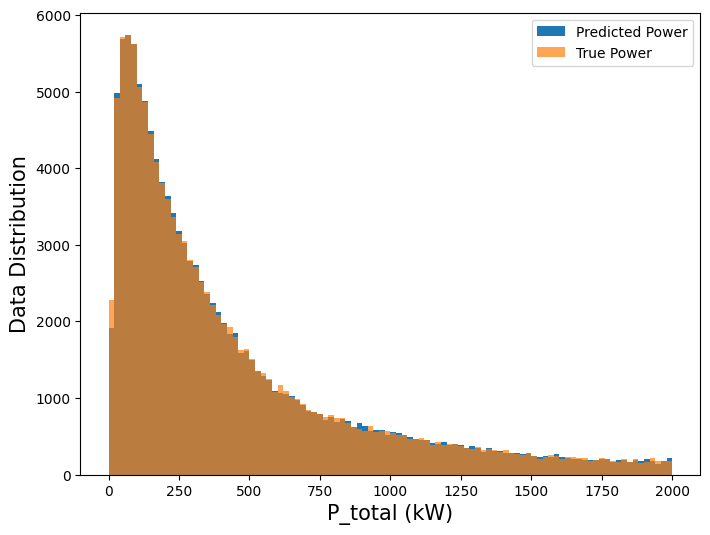

In [ ]:
""" features_dataset = pd.read_csv('./Dataset_test_features_UQ.csv')
P_dataset = pd.read_csv('./Dataset_test_P_UQ.csv')

# Remove the first column (unnamed) if it exists
features_dataset = features_dataset.drop(columns=['Unnamed: 0'], errors='ignore')
P_dataset = P_dataset.drop(columns=['Unnamed: 0'], errors='ignore')
print(P_dataset.columns)
print(features_dataset.columns)
print(P_dataset.shape)
print(features_dataset.shape)

# Plot distributions of P_res in kW
Ptotal_data = model_tf.predict(features_dataset)
plt.figure(figsize=(8,6))
plt.hist(Ptotal_data/1000, range=[0, 2000], bins=100,label='Predicted Power')
plt.xlabel('P_total (kW)',fontsize=15)
plt.ylabel('Data Distribution',fontsize=15)
#plt.title('Predicted Power',fontsize=20)
#plt.show()

Ptotal_data = P_dataset
#plt.figure(figsize=(4,4))
plt.hist(Ptotal_data/1000, range=[0, 2000], bins=100,label='True Power',alpha=0.7)
#plt.xlabel('P_total (kW)',fontsize=15)
#plt.ylabel('Data Distribution',fontsize=15)
#plt.title('True Power',fontsize=20)
plt.legend()
plt.show() """

# **Prepare data**

Load, preprocess and split dat into test and calibration sets

In [12]:
features_dataset = pd.read_csv('./Dataset_test_features_UQ.csv')
P_dataset = pd.read_csv('./Dataset_test_P_UQ.csv')

# Remove the first column (unnamed) if it exists
features_dataset = features_dataset.drop(columns=['Unnamed: 0'], errors='ignore')
P_dataset = P_dataset.drop(columns=['Unnamed: 0'], errors='ignore')

# Standarize Y data. X data is already standarized
P_mean = 444860.879260
P_std = 446349.165241
P_dataset = (P_dataset - P_mean) / P_std

# If your datasets are in Pandas format, you can set the sample size
sample_size = 10000  # Adjust as needed
# Take a random sample
features_sample = features_dataset.sample(n=sample_size, random_state=42)
P_sample = P_dataset.loc[features_sample.index]  # Use the same indices for P_dataset

print(P_dataset.columns)
print(features_dataset.columns)
print(P_dataset.shape)
print(features_dataset.shape)

print(P_sample.shape)
print(features_sample.shape)

Index(['P'], dtype='object')
Index(['V', 'theta', 'W', 'theta.1', 'nacelle_temperature', 'V.1',
       'Vane_angle', 'Out_temperature', 'W.1', 'Rotor_temperature',
       'Wind_angle_c'],
      dtype='object')
(120530, 1)
(120530, 11)
(10000, 1)
(10000, 11)


In [13]:
# Convert pd dataframe to numpy 
features_sample = features_sample.to_numpy()
P_sample = P_sample.to_numpy()

# Split data
X_cal, X_test, y_cal, y_test = train_test_split(features_sample, P_sample, test_size=0.5, random_state=42)
""" features_dataset = features_dataset.to_numpy()
P_dataset = P_dataset.to_numpy()
X_cal, X_test, y_cal, y_test = train_test_split(features_dataset, P_dataset, test_size=0.5, random_state=42) """
print(X_cal.shape)
print(y_cal.shape)
print(X_test.shape)
print(y_test.shape)

(5000, 11)
(5000, 1)
(5000, 11)
(5000, 1)


# **Train and save models**

Create, train and save Keras models:

* `model_up` with tau = (1-alpha)/2
* `model_low` with tau = alpha/2
* `model` with tau = 0.5

In [36]:
alpha = .1

def pinball_loss(y_true, y_pred, tau=0.5):
    error = y_true - y_pred
    return tf.reduce_mean(tf.maximum(tau * error, (tau - 1) * error))

def plot_loss(history):
    
    # Plot the loss
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss [P_res]')
    plt.legend()
    plt.grid(True)

    val_loss_per_epoch = history.history['val_loss']
    train_loss_per_epoch = history.history['loss']
    best_epoch = val_loss_per_epoch.index(min(val_loss_per_epoch)) + 1
    print('Best epoch: %d' % (best_epoch,))


Epoch 1/100
125/125 [==============================] - 1s 2ms/step - loss: 71719.2031 - val_loss: 8251.3857
Epoch 2/100
125/125 [==============================] - 0s 931us/step - loss: 6015.2822 - val_loss: 3552.1025
Epoch 3/100
125/125 [==============================] - 0s 953us/step - loss: 3412.1743 - val_loss: 2720.3018
Epoch 4/100
125/125 [==============================] - 0s 954us/step - loss: 2529.5396 - val_loss: 2112.2725
Epoch 5/100
125/125 [==============================] - 0s 959us/step - loss: 1948.7062 - val_loss: 1726.0153
Epoch 6/100
125/125 [==============================] - 0s 974us/step - loss: 1557.8019 - val_loss: 1465.8899
Epoch 7/100
125/125 [==============================] - 0s 929us/step - loss: 1285.2313 - val_loss: 1296.0923
Epoch 8/100
125/125 [==============================] - 0s 1ms/step - loss: 1080.9690 - val_loss: 1105.7755
Epoch 9/100
125/125 [==============================] - 0s 970us/step - loss: 922.1654 - val_loss: 1011.4145
Epoch 10/100
125/125 [=

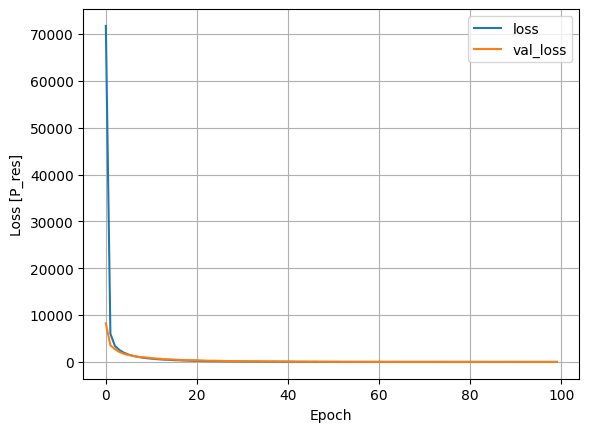

In [39]:
model_up = load_model('modelP.keras')
loss_fn = lambda y_true, y_pred: pinball_loss(y_true, y_pred, tau=(1-alpha)/2)
model_up.compile(optimizer='adam', loss=loss_fn)
history_up = model_up.fit(X_cal, y_cal, epochs=100, batch_size=32, validation_split=.2)
model_up.save('modelP_up.keras')
plot_loss(history_up)



Epoch 1/100
125/125 [==============================] - 1s 2ms/step - loss: 108416.9609 - val_loss: 6232.1504
Epoch 2/100
125/125 [==============================] - 0s 934us/step - loss: 5296.6016 - val_loss: 3291.6741
Epoch 3/100
125/125 [==============================] - 0s 964us/step - loss: 2664.6265 - val_loss: 1685.9939
Epoch 4/100
125/125 [==============================] - 0s 943us/step - loss: 1663.0398 - val_loss: 1216.0417
Epoch 5/100
125/125 [==============================] - 0s 952us/step - loss: 1198.7034 - val_loss: 1033.7756
Epoch 6/100
125/125 [==============================] - 0s 911us/step - loss: 1000.0602 - val_loss: 916.9041
Epoch 7/100
125/125 [==============================] - 0s 1ms/step - loss: 805.6218 - val_loss: 918.4106
Epoch 8/100
125/125 [==============================] - 0s 953us/step - loss: 723.5905 - val_loss: 745.2759
Epoch 9/100
125/125 [==============================] - 0s 964us/step - loss: 670.5446 - val_loss: 652.8941
Epoch 10/100
125/125 [======

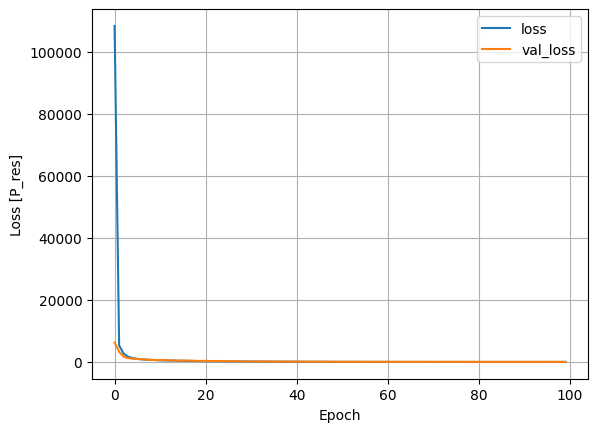

In [40]:
model_low = load_model('modelP.keras')
loss_fn = lambda y_true, y_pred: pinball_loss(y_true, y_pred, tau=alpha/2)
model_low.compile(optimizer='adam', loss=loss_fn)
history_low = model_low.fit(X_cal, y_cal, epochs=100, batch_size=32, validation_split=.2)
model_up.save('modelP_low.keras')
plot_loss(history_low)

# **MAPIE**

Load and wrap for `sklearn` compatibility (the wrapper assumes that the model is already trained):

In [14]:
class TrainedKerasRegressorWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, model):
        self.model = model

    def fit(self, X, y):
        return self

    def predict(self, X):
        return self.model.predict(X).flatten()

    def __sklearn_is_fitted__(self):
        return True

# loaded_model = load_model('model.keras')
# model = TrainedKerasRegressorWrapper(loaded_model)

#model_files = ['modelP_low.keras', 'modelP_up.keras', 'modelP.keras']
model_files = ['modelP.keras', 'modelP.keras', 'modelP.keras']
wrapped_models = []

for file in model_files:
    loaded_model = load_model(file, compile=False)
    wrapped_model = TrainedKerasRegressorWrapper(loaded_model)
    wrapped_models.append(wrapped_model)

MAPIE quantile regression.

The list of estimators consist of:

* [0]: Estimator with quantile value of alpha/2
* [1]: Estimator with quantile value of 1 - alpha/2
* [2]: Estimator with quantile value of 0.5
```

In [ ]:
mapie_regressor = MapieQuantileRegressor(
    estimator=wrapped_models, cv='prefit')

mapie_regressor.fit(X_cal, y_cal)

predictions, intervals = mapie_regressor.predict(X_test)

lower_intervals = intervals[:, 0]
upper_intervals = intervals[:, 1]

results = pd.DataFrame({
    'Prediction': predictions.flatten(),
    'Lower Interval': lower_intervals.flatten(),
    'Upper Interval': upper_intervals.flatten(),
    'Amplitude': upper_intervals.flatten() - lower_intervals.flatten(),
    'Actual Value': y_test
})

results.head()

/home/alfonso/Work/UGR/Calculations/WindTurbines_hybrid/WT_hybrid_venv/lib/python3.10/site-packages/mapie/regression/quantile_regression.py:201: UserWarning: WARNING: The alpha that is set needs to be the same as the alpha of your prefitted model in the following order [alpha/2, 1 - alpha/2, 0.5]
  warnings.warn(


157/157 [==============================] - 0s 500us/step


ValueError: could not broadcast input array from shape (5000,5000) into shape (5000,)